# Learn VAE on Game datasets


## Standard-Imports


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install keras


You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.



## Loading Datasets

- Mario Dataset includes multiple levels which can be combined
- The test set is made of levels that were previously not seen


In [3]:


downsampled = []
original = []
actions = []
rewards = []

import os
record_files = [filename for filename in os.listdir(f'./record/{game_name}')
                    if os.path.isfile(f"./record/{game_name}/{filename}") and filename.startswith(f"record_{game_name}_{output}")]
for file in record_files[0:10]:
    print("load file: ", file)
    data = np.load(f"./record/{game_name}/{file}", allow_pickle=True)
    if len(downsampled) == 0:
        downsampled = data["obs_downsampled"]
        original = data["obs_original"]
        actions = data["actions"]
        rewards = data["rewards"]
    else:
        downsampled = np.concatenate((downsampled, data["obs_downsampled"]))
        original = np.concatenate((original, data["obs_original"]))
        actions = np.concatenate((actions, data["actions"]))
        rewards = np.concatenate((rewards, data["rewards"]))


downsampled = data["obs_downsampled"]/255.
original = data["obs_original"]/255.
actions = data["action"]


short test of trainings process with train test split on a single level


In [4]:
print(downsampled.shape)
print(original.shape)

(1999, 64, 64, 3)
(1999, 240, 256, 3)


In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(downsampled, downsampled,
                                                    test_size=0.25)


(1499, 64, 64, 3)
(500, 64, 64, 3)


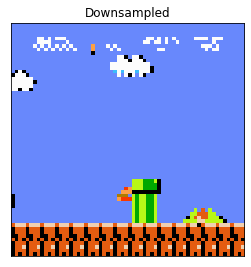

In [90]:
import random
index = random.choice(range(len(X_train)))
plt.imshow(X_train[index,:,:,:])
plt.title("Downsampled")
plt.tight_layout()
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.show()


## Simple Auto-Encoder


In [23]:

from keras.datasets import mnist
import numpy as np

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(64, 64, 3))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = UpSampling2D((2, 2))(encoded)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


In [25]:
autoencoder.fit(X_train, X_train,
                epochs=10,
                batch_size=16,
                shuffle=True,
                validation_data=(X_test, X_test))


Train on 1499 samples, validate on 500 samples
Epoch 1/10
1499/1499 [==============================] - 13s 9ms/step - loss: 0.4872 - val_loss: 0.4826
Epoch 2/10
1499/1499 [==============================] - 12s 8ms/step - loss: 0.4793 - val_loss: 0.4763
Epoch 3/10
1499/1499 [==============================] - 12s 8ms/step - loss: 0.4747 - val_loss: 0.4726
Epoch 4/10
1499/1499 [==============================] - 13s 9ms/step - loss: 0.4718 - val_loss: 0.4705
Epoch 5/10
1499/1499 [==============================] - 12s 8ms/step - loss: 0.4699 - val_loss: 0.4687
Epoch 6/10
1499/1499 [==============================] - 12s 8ms/step - loss: 0.4684 - val_loss: 0.4676
Epoch 7/10
1499/1499 [==============================] - 12s 8ms/step - loss: 0.4671 - val_loss: 0.4662
Epoch 8/10
1499/1499 [==============================] - 12s 8ms/step - loss: 0.4660 - val_loss: 0.4653
Epoch 9/10
1499/1499 [==============================] - 12s 8ms/step - loss: 0.4650 - val_loss: 0.4641
Epoch 10/10
1499/1499 [===

In [26]:
img = X_train[1:3,:,:,:]
print(img.shape)
pred = autoencoder.predict(img)
print(pred.shape)


(2, 64, 64, 3)
(2, 64, 64, 3)


In [27]:
print(pred)

[[[[0.35918653 0.45556748 0.886019  ]
   [0.39351666 0.5792366  0.965675  ]
   [0.44681215 0.5595126  0.9755056 ]
   ...
   [0.44328916 0.5550864  0.9765773 ]
   [0.43063998 0.5784656  0.97943926]
   [0.38479394 0.563435   0.94342214]]

  [[0.43840635 0.51151437 0.9636519 ]
   [0.45480385 0.61305314 0.98738205]
   [0.5057956  0.5762263  0.99177164]
   ...
   [0.50099635 0.5681097  0.99200666]
   [0.5048401  0.6040462  0.99344397]
   [0.50575393 0.56074244 0.97303176]]

  [[0.45304978 0.555299   0.96968293]
   [0.45979103 0.6486559  0.98881423]
   [0.48019922 0.59946084 0.9922309 ]
   ...
   [0.46404943 0.57511014 0.99196684]
   [0.46858335 0.6130188  0.9934948 ]
   [0.44573048 0.54471254 0.9703921 ]]

  ...

  [[0.8690634  0.6068469  0.23753533]
   [0.92262745 0.6931982  0.25061047]
   [0.8984611  0.59559727 0.24077475]
   ...
   [0.9106797  0.5637832  0.3062991 ]
   [0.91402906 0.6274474  0.4579694 ]
   [0.7762932  0.54446524 0.5778402 ]]

  [[0.6766544  0.49056566 0.20294735]
   [0.7

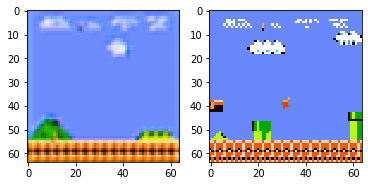

In [29]:
img = 1
fig, [ax1, ax2] = plt.subplots(1,2)
ax1.imshow(pred[img,:,:,:].reshape((64,64,3)))
ax2.imshow(X_train[img,:,:,:])
plt.show()


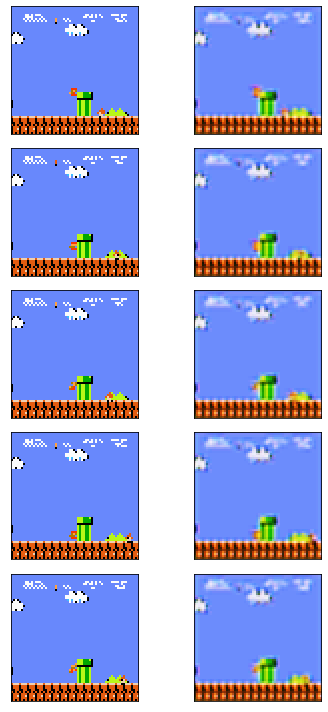

In [48]:

decoded_imgs = autoencoder.predict(X_test)

n = 5
_, ax = plt.subplots(n,2, figsize=(6,10))

for i in range(n):
    # display original
    ax[i,0].imshow(X_test[i,:,:,:].reshape(64, 64, 3))
    ax[i,0].get_xaxis().set_visible(False)
    ax[i,0].get_yaxis().set_visible(False)
    
    # display reconstruction
    ax[i,1].imshow(decoded_imgs[i,:,:,:].reshape(64, 64, 3))
    ax[i,1].get_xaxis().set_visible(False)
    ax[i,1].get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()
    


## Simple Convolutional Variational Auto-Encoder


In [73]:
from datasetextraction.vae.vae import ConvVAE, reset_graph

# Hyperparameters for ConvVAE
z_size=32
batch_size=100
learning_rate=0.0001
kl_tolerance=0.5

vae = ConvVAE(z_size=z_size,
              batch_size=batch_size,
              learning_rate=learning_rate,
              kl_tolerance=kl_tolerance,
              is_training=True,
              reuse=False,
              gpu_mode=True)

NUM_EPOCH = 50
dataset = X_train

total_length = len(dataset)

reset_graph()


num_batches = int(np.floor(total_length/batch_size))


# train loop:
print("train", "step", "loss", "recon_loss", "kl_loss")
for epoch in range(NUM_EPOCH):
  np.random.shuffle(dataset)
  for idx in range(num_batches):
    batch = dataset[idx*batch_size:(idx+1)*batch_size]

    obs = batch.astype(np.float)

    feed = {vae.x: obs,}

    (train_loss, r_loss, kl_loss, train_step, _) = vae.sess.run([
      vae.loss, vae.r_loss, vae.kl_loss, vae.global_step, vae.train_op
    ], feed)
  
    if ((train_step+1) % 10 == 0):
      print("step", (train_step+1), train_loss, r_loss, kl_loss)
    if ((train_step+1) % 5000 == 0):
      vae.save_json("tf_vae/vae.json")
          

INFO:tensorflow:Model using gpu.
train step loss recon_loss kl_loss
step 10 1255.3911 1239.3911 16.0
step 20 1166.1091 1147.4756 18.633484
step 30 913.796 867.3653 46.430756
step 40 738.03217 718.6462 19.386007
step 50 651.41705 634.80475 16.612297
step 60 595.4184 576.91974 18.498678
step 70 560.232 543.785 16.447046
step 80 533.7657 517.4232 16.342463
step 90 498.6302 482.33676 16.293442
step 100 452.6871 433.19003 19.497065
step 110 398.04852 375.559 22.489534
step 120 341.83273 320.0673 21.76545
step 130 294.12988 272.9676 21.162294
step 140 265.6855 247.44777 18.237717
step 150 235.26189 216.59904 18.662848
step 160 236.55075 218.6297 17.921055
step 170 186.52086 169.20348 17.317377
step 180 194.49643 176.91467 17.58175
step 190 202.29657 184.54012 17.756447
step 200 172.1044 153.96375 18.140648
step 210 174.07925 157.46396 16.61529
step 220 172.9826 156.35057 16.632027
step 230 184.39551 164.25642 20.139091
step 240 159.83972 139.9891 19.85061
step 250 170.69463 153.487 17.20763


In [72]:
idx = 0
mu, logvar = vae.encode_mu_logvar(X_train[idx*batch_size:(idx+1)*batch_size,:,:,:].reshape((100,64,64,3)))

#a = vae.encode(X_train[idx*batch_size:(idx+1)*batch_size,:,:,:].reshape((100,64,64,3)))
#print(a.shape)
#decoded_imgs = vae.decode(a)
print(logvar)


[[-0.69949585 -0.7399228  -0.8483006  ... -0.6878013  -0.93363786
  -0.58265144]
 [-0.71084666 -0.756896   -0.85031164 ... -0.6830697  -0.9402207
  -0.59607774]
 [-0.69072783 -0.74020904 -0.8344785  ... -0.6869505  -0.92492974
  -0.57683825]
 ...
 [-0.7127757  -0.76121354 -0.85019207 ... -0.6855673  -0.943413
  -0.60372025]
 [-0.6988505  -0.759919   -0.85101485 ... -0.6764121  -0.95368475
  -0.58792555]
 [-0.70528156 -0.7552532  -0.84870875 ... -0.68519866 -0.93869185
  -0.58549684]]


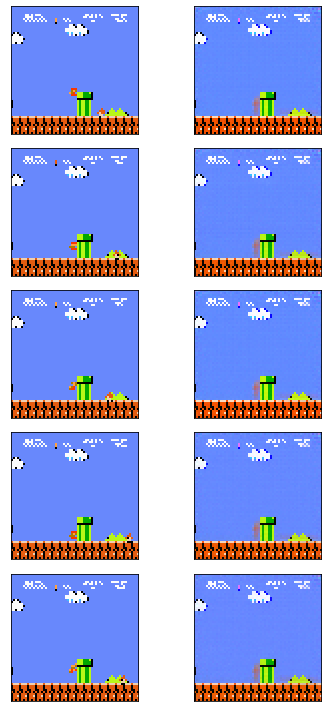

In [71]:

n = 5
_, ax = plt.subplots(n,2, figsize=(6,10))

for i in range(n):
    # display original
    ax[i,0].imshow(X_test[i,:,:,:].reshape(64, 64, 3))
    ax[i,0].get_xaxis().set_visible(False)
    ax[i,0].get_yaxis().set_visible(False)
    
    # display reconstruction
    ax[i,1].imshow(decoded_imgs[i,:,:,:].reshape(64, 64, 3))
    ax[i,1].get_xaxis().set_visible(False)
    ax[i,1].get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()
    
    


# MNIST 


In [7]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format


from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [8]:
print(x_train.shape)
print(x_train)
print(x_test.shape)
print(x_train.shape)
print(x_test.shape)

autoencoder.fit(x_train, x_train,
                epochs=1,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))


(60000, 28, 28, 1)
[[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0

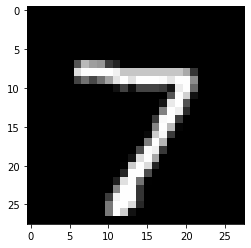

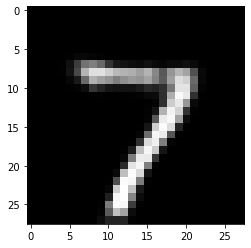

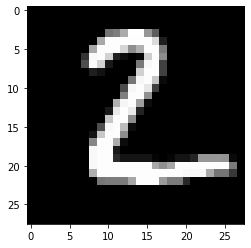

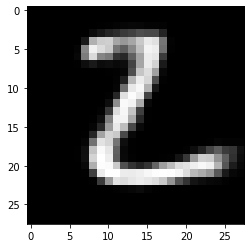

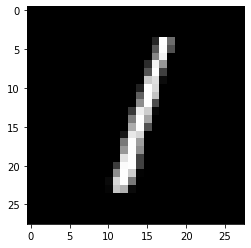

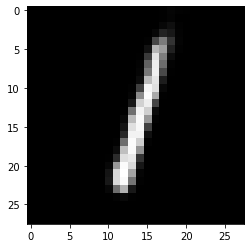

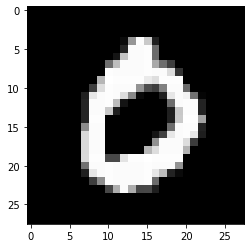

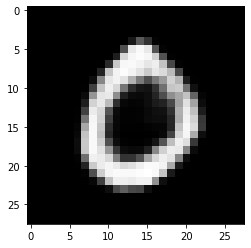

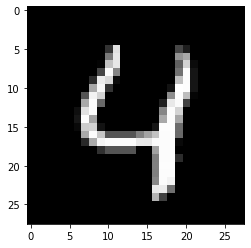

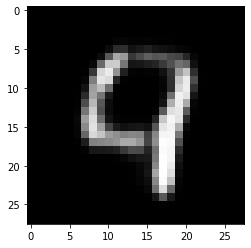

In [56]:

decoded_imgs = autoencoder.predict(x_test)

n = 5
for i in range(n):
    # display original
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    plt.show()
    # display reconstruction
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    plt.show()
    

In [55]:
x_test[0].shape




(28, 28, 1)

In [91]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(64,64,3))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

#x = Conv2D(8, (2, 2), activation='relu', padding='same')(encoded)
#x = UpSampling2D((2, 2))(encoded)
#decoded = Conv2D(3, (2, 2), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, x)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.output_shape


(None, 8, 8, 8)